# Analysis of US healthcare spend - Data

---
## Raw data

Raw data is sourced from the following sites:

### Inpatient Charge Data (2011 - 2017)

Source: https://www.cms.gov/Research-Statistics-Data-and-Systems/Statistics-Trends-and-Reports/Medicare-Provider-Charge-Data/Inpatient2017

This data set provides the charges and payments of healthcare procedures over time. The Inpatient Utilization and Payment Public Use File (Inpatient PUF) provides information on inpatient discharges for Medicare fee-for-service beneficiaries. The Inpatient PUF includes information on utilization, payment (total payment and Medicare payment), and hospital-specific charges for the more than 3,000 U.S. hospitals that receive Medicare Inpatient Prospective Payment System (IPPS) payments.  Charges are for 100 diagnoses in years 2011-2013 and for 560 diagnoses for years 2014-2017.

|Column|Type|Dataset|Description|
|---|---|---|---|
|DRG Definition|string |Inpatient charge data|Code and description of diagnosis|
|Provider Id|int|Inpatient charge data|Id assigned to Medicare-certified facility|
|Provider Name|string|Inpatient charge data|Name of provider/ facility|
|Provider Street Address|string|Inpatient charge data|Provider address|
|Provider City|string|Inpatient charge data|City where provider is located|
|Provider State|string|Inpatient charge data|State where the provider is located|
|Provider Zip Code|int|Inpatient charge data|Zip where the provider is located|
|Hospital Referral Region|string|Inpatient charge data|Region where the provider is located|
|Total Discharges|int|Inpatient charge data|Number of patientsbilled by the provider|
|Average Covered Charges|float|Inpatient charge data|What the provider charges for that DRG/ diagnosis|
|Average Total Payments|float|Inpatient charge data|Average total payments for the DRG. Also included in average total payments are co-payment and deductible amounts that the patient is responsible for and any additional payments by third parties for coordination of benefits|
|Average Medicare Payments|float|Inpatient charge data|Average amount that Medicare pays to the provider for Medicare's share of the DRG|


### United States Senate, Lobby Disclosure Act Reports

Source: https://www.senate.gov/legislative/Public_Disclosure/LDA_reports.htm

This data set provides reports on lobbist funding for 50 states from 1999-2019, based on the US Lobby Disclosure Act.

|Column|Type|Dataset|Description|
|---|---|---|---|
|State|string|LDA Report|State where client is located|
|Registrant Name|string|LDA Reports|Name of registrant/ lobbyist|
|Client Name|string|LDA Reports|Name client|
|Filing Type|string|LDA Reports|Type of report/ reporting period|
|Amount Reported|float|LDA Reports|Amount of funds client sent thru lobbyist|
|Date Posted|string|LDA Reports|Date report posted|
|Filing Year|int|LDA Reports|Filing year|



### United States Census Data

Source: https://www.census.gov/data/tables/time-series/demo/popest/2010s-state-total.html

Provides population of 50 states from the 2010 census. 

|Column|Type|Dataset|Description|
|---|---|---|---|
|State|string|US Census population|US State|
|Population|int| US Census Population|Population for that US state|

---

## 1. Importing tools 

In [ ]:
import requests
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
import time
import ipywidgets as widget
import string

## 2. Clean the data for hospital charges and payments

In [2]:
# Import my data into a 'c' costs dictionary of dataframes, keyed for each year
c={}
my_years = [2011, 2012, 2013, 2014, 2015, 2016, 2017]
for yr in my_years:
    c[yr] = pd.read_csv(f'./data/costs/costs_{yr}.csv')

In [3]:
c[2011].head(2)

,DRG Definition,Provider Id,Provider Name,Provider Street Address,Provider City,Provider State,Provider Zip Code,Hospital Referral Region Description,Total Discharges,Average Covered Charges,Average Total Payments,Average Medicare Payments
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,91,32963.07,5777.24,4763.73
1,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,AL - Birmingham,14,15131.85,5787.57,4976.71


In [4]:
# clean my data
for yr in my_years:
    # for every df in my dictionary, change the col names, annotate the years
    c[yr].columns = ['diagnosis', 'id', 'name','address','city','state','zip','region',
       f'ave_discharged_{yr}', f'ave_charged_{yr}', f'ave_paid_{yr}', f'ave_medicare_{yr}']
    
    # drop cols I won't be using
    c[yr].drop(columns = ['id', 'name', 'address', 'city', 'zip', 'region'],inplace= True)
    
    # truncate our Diagnosis Related Group description to 3 digit string
    c[yr].diagnosis = c[yr].diagnosis.str[0:3]
    
    # We drop DC as a state
    c[yr].drop(c[yr][c[yr]['state'] == 'DC'].index, inplace=True)    
 
    # Let's consolidate all the state data by diagnosis, and get the mean of what each state charges/ is paid
    c[yr]=c[yr].groupby(['state','diagnosis'],as_index=False).mean()


    # Engineer/ add feature = this col compares the cost of a procedure vs what medicare pays
    c[yr][f'charge_over_med_{yr}'] = (c[yr][f'ave_charged_{yr}'] - c[yr][f'ave_medicare_{yr}']
                                     ) / c[yr][f'ave_medicare_{yr}']

    # this col compares the average amount paid for a procedure vs what medicare pays
    c[yr][f'paid_over_med_{yr}'] = (c[yr][f'ave_paid_{yr}'] - c[yr][f'ave_medicare_{yr}']
                                     ) / c[yr][f'ave_medicare_{yr}']             
    
    # Interesting ovservation - number of recorded DRGs wen up from 100 to 560+
    print(f'YR={yr}, SHAPE={c[yr].shape}, STATES={len(c[yr].state.unique())},  DIAGNOSES={len(c[yr].diagnosis.unique())}')
    
print('Summy of dictionary with yearly healthcare charge and payment data')

YR=2011, SHAPE=(4925, 8), STATES=50,  DIAGNOSES=100
YR=2012, SHAPE=(4939, 8), STATES=50,  DIAGNOSES=100
YR=2013, SHAPE=(4937, 8), STATES=50,  DIAGNOSES=100
YR=2014, SHAPE=(14809, 8), STATES=50,  DIAGNOSES=564
YR=2015, SHAPE=(15024, 8), STATES=50,  DIAGNOSES=563
YR=2016, SHAPE=(15239, 8), STATES=50,  DIAGNOSES=573
YR=2017, SHAPE=(15223, 8), STATES=50,  DIAGNOSES=563
Summy of dictionary with yearly healthcare charge and payment data


In [14]:
# We me merge all the years into one dataframe
# data is merged on the State and the diagnosis (DRG)
merge1 = c[2011].merge(c[2012], on=['state','diagnosis'])
print(merge1.shape)

merge2 = merge1.merge(c[2013], on=['state','diagnosis'])
print(merge2.shape)

merge3 = merge2.merge(c[2014], on=['state','diagnosis'])
print(merge3.shape)

merge4 = merge3.merge(c[2015], on=['state','diagnosis'])
print(merge4.shape)

merge5 = merge4.merge(c[2016], on=['state','diagnosis'])
print(merge5.shape)

merge6 = merge5.merge(c[2017], on=['state','diagnosis'])
print(merge6.shape)


(4819, 14)
(4659, 20)
(4641, 26)
(4582, 32)
(4494, 38)
(4468, 44)


In [15]:
# Data is merged on the state and diagnosis
# We have 93 diagnoses
common_diagnoses=(np.unique(merge6.diagnosis))
len(common_diagnoses)

93

In [16]:
#create new col representing BOTH STATE and diagnosis
merge6['STdiag']=merge6.state+merge6.diagnosis
merge6.drop(columns = ['state', 'diagnosis'],inplace= True)
merge6 = merge6.set_index('STdiag')
#drop old cols and make new col the index

#Transpose!
data = merge6.T
data=data.reset_index()
data.rename(columns = {'index':'ave_data'}, inplace = True)

#create new cols for STATE median for all 93 procedures
my_states = ['AK','AL','AR','AZ','CA','CO','CT','DE','FL','GA','HI','IA','ID',
             'IL','IN','KS','KY','LA','MA','MD','ME','MI','MN','MO','MS',
             'MT','NC','ND','NE','NH','NJ','NM','NV','NY','OH','OK','OR','PA',
             'RI','SC','SD','TN','TX','UT','VA','VT','WA','WI','WV','WY']

for st in my_states:
    data[f'{st}all']= data.filter(like= st).median(axis=1)

data.head()

STdiag,ave_data,AK039,AK064,AK065,AK066,AK101,AK176,AK177,AK189,AK190,...,SDall,TNall,TXall,UTall,VAall,VTall,WAall,WIall,WVall,WYall
0,ave_discharged_2011,23.000000,22.500000,25.333333,21.000000,19.500000,26.00000,14.500000,24.000000,23.285714,...,27.583333,33.758621,29.789474,22.000000,30.321429,29.500000,25.833333,25.259259,29.052632,22.000000
1,ave_charged_2011,34805.130000,42453.810000,32629.370000,25843.322500,23156.085000,35672.65000,61224.635000,45137.093333,33169.691429,...,24257.994667,22918.886066,32769.518395,19871.853636,22399.921905,16199.150000,24974.775171,20396.486364,15737.700714,23809.538750
2,ave_paid_2011,8401.950000,21608.010000,12555.548333,9275.867500,7682.735000,10349.50000,16333.210000,11854.953333,13414.714286,...,7916.021571,6612.036250,7560.220311,7792.068333,7223.536222,9888.220000,8030.231872,7594.615577,6789.610769,9873.196250
3,ave_medicare_2011,6413.780000,20555.255000,11140.963333,8258.427500,5942.060000,7460.65000,15395.450000,10847.556667,12098.165714,...,6597.558810,5535.923958,6333.127486,6163.990714,5938.415373,8684.030000,6670.433453,6105.764259,5772.969091,8403.470625
4,charge_over_med_2011,4.426617,1.065351,1.928775,2.129327,2.896979,3.78144,2.976801,3.161038,1.741712,...,2.412167,3.303860,4.320847,2.192585,3.001546,0.927788,2.919880,2.274726,1.821586,1.979725


In [176]:
for st in my_states:
    data['USall']= data.filter(like= 'all').mean(axis=1)
    
data.head(2)

STdiag,ave_data,AK039,AK064,AK065,AK066,AK101,AK176,AK177,AK189,AK190,...,TNall,TXall,UTall,VAall,VTall,WAall,WIall,WVall,WYall,USall
0,ave_discharged_2011,23.00,22.50,25.333333,21.0000,19.500,26.00,14.500,24.000000,23.285714,...,33.758621,29.789474,22.000000,30.321429,29.50,25.833333,25.259259,29.052632,22.00000,28.377526
1,ave_charged_2011,34805.13,42453.81,32629.370000,25843.3225,23156.085,35672.65,61224.635,45137.093333,33169.691429,...,22918.886066,32769.518395,19871.853636,22399.921905,16199.15,24974.775171,20396.486364,15737.700714,23809.53875,25265.942660


In [30]:
# Lets look at charges and payments for the states
def my_statecost1(state_choice1):
    plt.figure(figsize=(16,8))
    plt.title(f'Hospital charges and payements in {state_choice1} (median 93 procedures)', fontsize=25)
    
    y = data[data['ave_data'].str.contains("ave_paid")][f'{state_choice1}all']
    y2 = data[data['ave_data'].str.contains("ave_medicare")][f'{state_choice1}all']
    y3 = data[data['ave_data'].str.contains("ave_charged")][f'{state_choice1}all']
    plt.plot(my_years, y3,label = 'Median charge for diagnosis')
    plt.plot(my_years, y, label = 'Median payment by all')
    plt.plot(my_years, y2,label = 'Median payment by Medicare')
    
    plt.xlabel('Year',fontsize=20)
    plt.ylabel('Charged by/ Paid to hospitals',fontsize=20)
    #plt.ylim(6000, 18000)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.legend(loc='best');
    

state_slider1 = widget.SelectionSlider(
    options=my_states,
    value='AK',
    description='State:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True
    #layout ={'width':'1000px'}
    )


widget.interact(my_statecost1 , state_choice1=state_slider1)        

interactive(children=(SelectionSlider(continuous_update=False, description='State:', options=('AK', 'AL', 'AR'…

<function __main__.my_statecost1(state_choice1)>

In [31]:
def my_statecost2(state_choice2,diagnosis_choice):
    plt.figure(figsize=(16,8))
    plt.title(f'How much hospitals charge in {state_choice2} for procedure {diagnosis_choice}', fontsize=25)
    
    y = data[data['ave_data'].str.contains("ave_charged")][f'{state_choice2}{diagnosis_choice}']
    y2 = data[data['ave_data'].str.contains("ave_paid")][f'{state_choice2}{diagnosis_choice}']
    y3 = data[data['ave_data'].str.contains("ave_medicare")][f'{state_choice2}{diagnosis_choice}']
    plt.plot(my_years, y, label = 'Hospital charge ')
    plt.plot(my_years, y2,label = 'Ave payment')
    plt.plot(my_years, y3,label = 'Ave payment by Medicare')
    
    plt.xlabel('Year',fontsize=20)
    plt.ylabel('Paid to hospitals',fontsize=20)
    #lt.ylim(6000, 18000)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.legend(loc='best');
    
state_slider2 = widget.SelectionSlider(
    options=my_states,
    value='AK',
    description='State:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True
    #layout ={'width':'1000px'}
    )

diagnosis_slider = widget.SelectionSlider(
    options=common_diagnoses,
    value='039',
    description='Diagnosis code:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True
    #layout ={'width':'1000px'}
    )

widget.interact(my_statecost2, state_choice2=state_slider2, diagnosis_choice=diagnosis_slider)        


interactive(children=(SelectionSlider(continuous_update=False, description='State:', options=('AK', 'AL', 'AR'…

<function __main__.my_statecost2(state_choice2, diagnosis_choice)>

In [186]:
def my_statcosts3(state_choice3,state_choice4):
    plt.figure(figsize=(16,8))
    plt.title(f'Comparing hospital charges and payments in {state_choice3} and {state_choice4} (ave 93 proc)', fontsize=25)
 
    #y1= data[data['ave_data'].str.contains("ave_charged")][f'{state_choice3}all']
    y2 = data[data['ave_data'].str.contains("ave_paid")][f'{state_choice3}all']
    y3 = data[data['ave_data'].str.contains("ave_medicare")][f'{state_choice3}all']
    
    #y4 = data[data['ave_data'].str.contains("ave_charged")][f'{state_choice4}all']
    y5 = data[data['ave_data'].str.contains("ave_paid")][f'{state_choice4}all']
    y6 = data[data['ave_data'].str.contains("ave_medicare")][f'{state_choice4}all']    
    
    #plt.plot(my_years, y1,
     #        color = 'lightgreen',
      #       linestyle = 'dotted',
       #      marker = 'o',
        #     label = f'{state_choice3} Median charge for diagnosis')
    plt.plot(my_years, y2,
             color = 'green',
             linestyle = 'dashed',
             marker = '^',
             label = f'{state_choice3} Median payment by all')
    plt.plot(my_years, y3,
             color = 'darkgreen',
             linestyle = 'solid',
             marker = 's',
             label = f'{state_choice3} Median payment by Medicare')
    
    #plt.plot(my_years, y4,
     #        color = 'orange',
      #       linestyle = 'dotted',
       #      marker = 'o',             
        #     label = f'{state_choice4} Median charge for diagnosis')
    plt.plot(my_years, y5,
             color = 'red',
             linestyle = 'dashed',
             marker = '^',
             label = f'{state_choice4} Median payment by all')
    plt.plot(my_years, y6,
             color = 'darkred',
             linestyle = 'solid',
             marker = 's',
             label = f'{state_choice4} Median payment by Medicare')     
                                                                
                                                                
    plt.xlabel('Year',fontsize=20)
    plt.ylabel('Paid to hospitals',fontsize=20)
    #lt.ylim(6000, 18000)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.legend(loc='best');
    
state_select3 = widget.Select(
    options=my_states,
    value='AL',
    #rows=10,
    description='State1:',
    disabled=False
    )
    
state_select4 = widget.Select(
    options=my_states,
    value='CT',
    #rows=10,
    description='State2:',
    disabled=False
    )    

widget.interact(my_statcosts3, state_choice3=state_select3, state_choice4= state_select4)   

interactive(children=(Select(description='State1:', index=1, options=('AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT'…

<function __main__.my_statcosts3(state_choice3, state_choice4)>

No handles with labels found to put in legend.


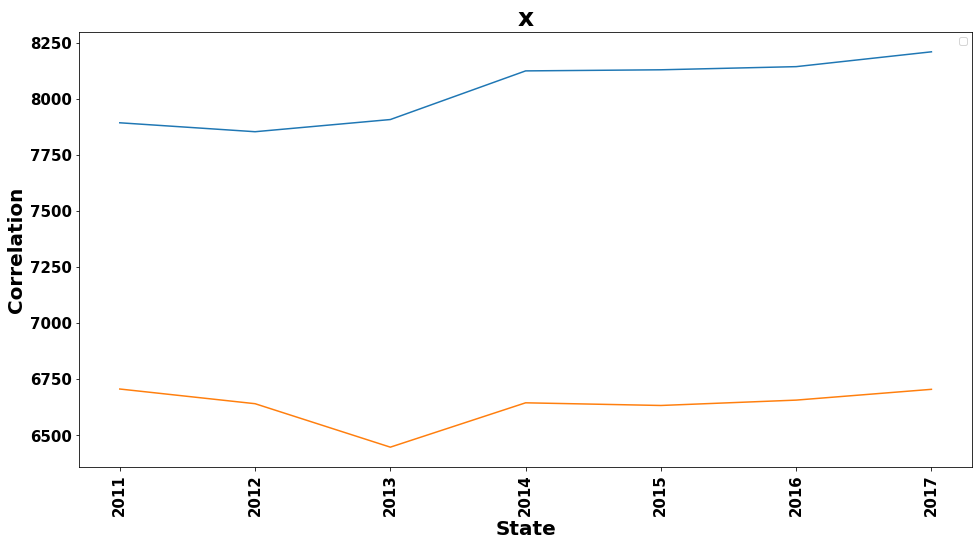

In [187]:
# PLOT correlation

y1 = data[data['ave_data'].str.contains("ave_paid")]['USall']
y2 = data[data['ave_data'].str.contains("ave_medicare")]['USall']


plt.figure(figsize=(16,8))
plt.title('x', fontsize = 25)
plt.plot(my_years, y1)
plt.plot(my_years,y2)
plt.xlabel('State',fontsize=20)
plt.ylabel('Correlation',fontsize=20)
plt.xticks(fontsize=15, rotation = 90)
plt.yticks(fontsize=15)
plt.legend(loc='best');


In [188]:
# calculate Pearsn correlation for US
#pcs = {}
#pps = {}

x = data[data['ave_data'].str.contains("ave_paid")]['USall']
y = data[data['ave_data'].str.contains("ave_medicare")]['USall']
pcs = scipy.stats.pearsonr(x, y)[0]
pps = scipy.stats.pearsonr(x, y)[1]
    
pcs,pps

(0.3651961134517521, 0.4205256367375443)

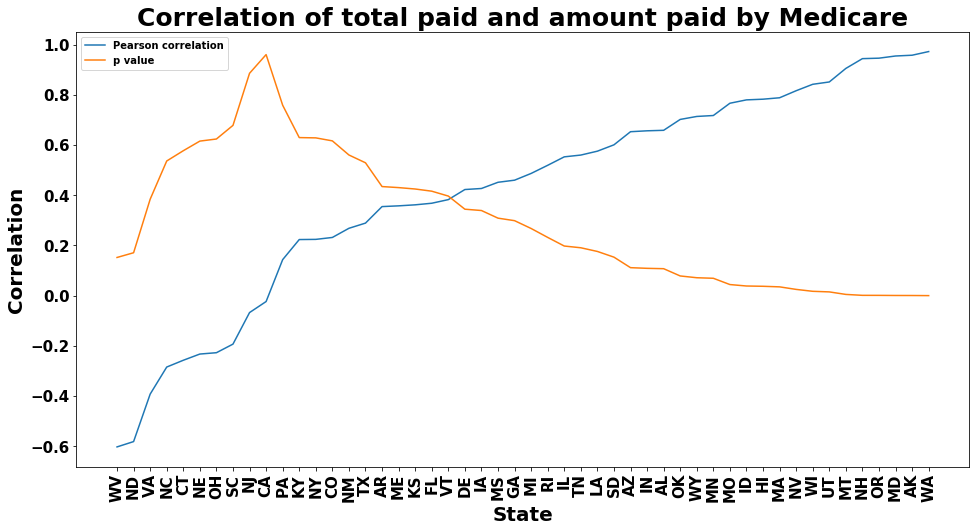

In [20]:
# calculate Pearsn correlation PER STATE
pc = {}
pp = {}
for state in my_states:
    x = data[data['ave_data'].str.contains("ave_paid")][f'{state}all']
    y = data[data['ave_data'].str.contains("ave_medicare")][f'{state}all']
    pc[state] = scipy.stats.pearsonr(x, y)[0]
    pp[state] = scipy.stats.pearsonr(x, y)[1]
    
p_corr = pd.DataFrame([pc,pp]).T
p_corr.rename(columns ={0:'corr', 1:'pvalue'}, inplace=True)
p_corr.sort_values(by=['corr'], inplace=True)

# PLOT correlation
plt.figure(figsize=(16,8))
plt.title('Correlation of total paid and amount paid by Medicare', fontsize = 25)
plt.plot(p_corr['corr'], label = 'Pearson correlation')
plt.plot(p_corr.pvalue, label = 'p value')
plt.xlabel('State',fontsize=20)
plt.ylabel('Correlation',fontsize=20)
plt.xticks(fontsize=15, rotation = 90)
plt.yticks(fontsize=15)
plt.legend(loc='best');


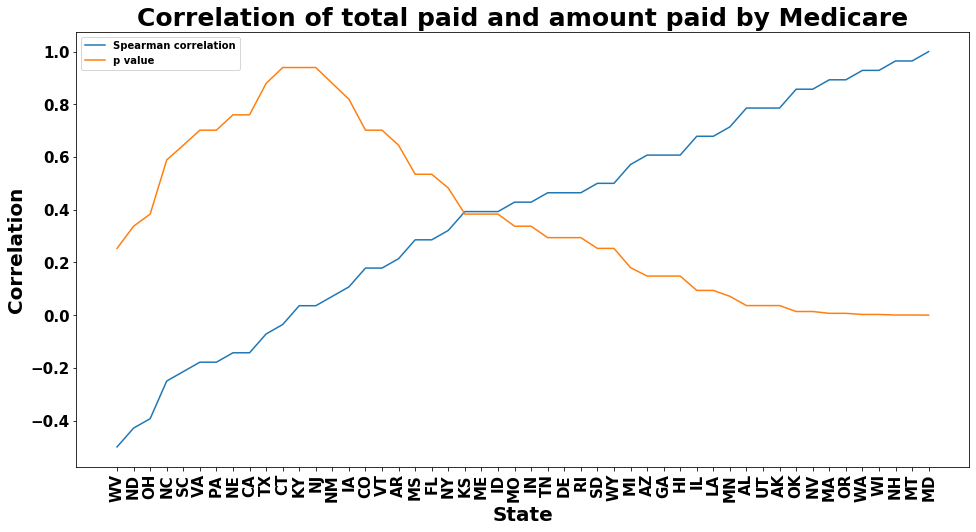

In [21]:
# calculate Spearman correlation
sc = {}
sp = {}
for state in my_states:
    x = data[data['ave_data'].str.contains("ave_paid")][f'{state}all']
    y = data[data['ave_data'].str.contains("ave_medicare")][f'{state}all']
    sc[state] = scipy.stats.spearmanr(x, y)[0]
    sp[state] = scipy.stats.spearmanr(x, y)[1]
    
sp_corr = pd.DataFrame([sc,sp]).T
sp_corr.rename(columns ={0:'corr', 1:'pvalue'}, inplace=True)
sp_corr.sort_values(by=['corr'], inplace=True)

# PLOT correlation
plt.figure(figsize=(16,8))
plt.title('Correlation of total paid and amount paid by Medicare', fontsize = 25)
plt.plot(sp_corr['corr'], label = 'Spearman correlation')
plt.plot(sp_corr.pvalue, label = 'p value')
plt.xlabel('State',fontsize=20)
plt.ylabel('Correlation',fontsize=20)
plt.xticks(fontsize=15, rotation = 90)
plt.yticks(fontsize=15)
plt.legend(loc='best');

### Read in US population data, from 2010 Census

In [22]:
pop=pd.read_csv('./data/states/population.csv')

In [23]:
pop.head()

,state,population
0,AL,4779736
1,AK,710231
2,AZ,6392017
3,AR,2915918
4,CA,37253956


### Read in Lobby Disclosure Act reports

In [263]:
# Import my data into 's' states dictionary of dataframes, keyed for each state
s={}
for st in my_states:
    s[st] = pd.read_csv(f'./data/states/{st}.csv')

In [275]:
foo = s['AL']
foo.shape

(839, 9)

In [276]:
foo['Date Posted'] = pd.to_datetime(foo['Date Posted'])
foo.sort_values(by=['Date Posted'], inplace = True)
foo['type'] = foo['Filing Type'].map(lambda val: val.split()[-1])
foo['period'] = foo['Filing Type'].map(lambda val: val.rsplit(' ',1)[0])


,State,Registrant Name,Client Name,Filing Type,Amount Reported,Date Posted,Filing Year,type,period
8,AL,"ADCOCK, MICHAEL W",COOPER GREEN HOSPITAL,REGISTRATION,NaN,1999-07-12,1999,REGISTRATION,REGISTRATION
392,AL,Jay Grant & Associates,PROTECTIVE LIFE INSURANCE CO,REGISTRATION,NaN,1999-07-26,1999,REGISTRATION,REGISTRATION
302,AL,"Drummond Company, Inc.",DRUMMOND COMPANY INC,MID-YEAR REPORT,"$100,000.00",1999-08-10,1999,REPORT,MID-YEAR
10,AL,"ADCOCK, MICHAEL W",COOPER GREEN HOSPITAL,MID-YEAR REPORT,"$20,000.00",1999-08-16,1999,REPORT,MID-YEAR
712,AL,US Strategies,CAREMARK,MID-YEAR AMENDMENT,"$20,000.00",1999-08-27,1999,AMENDMENT,MID-YEAR
60,AL,Ben Barnes Group LP,TORCHMARK CORP,REGISTRATION,NaN,1999-10-15,1999,REGISTRATION,REGISTRATION
394,AL,Jay Grant & Associates,PROTECTIVE LIFE INSURANCE CO,REGISTRATION,NaN,1999-12-13,1999,REGISTRATION,REGISTRATION
72,AL,BLUE CROSS AND BLUE SHIELD OF ALABAMA,Blue Cross and Blue Shield of Alabama,YEAR-END REPORT,NaN,2000-02-03,1999,REPORT,YEAR-END
58,AL,Ben Barnes Group LP,TORCHMARK CORP,YEAR-END REPORT,"$100,000.00",2000-02-08,1999,REPORT,YEAR-END
390,AL,Jay Grant & Associates,PROTECTIVE LIFE INSURANCE CO,YEAR-END REPORT,"$40,000.00",2000-02-15,1999,REPORT,YEAR-END


In [282]:
foo = foo.drop_duplicates(subset = ['State', 'Client Name', 'Filing Year','period'], keep = 'last')

,State,Registrant Name,Client Name,Filing Type,Amount Reported,Date Posted,Filing Year,type,period
17,AL,ALSTON & BIRD LLP,HEALTH SOUTH CORPORATION,YEAR-END REPORT,"$20,000.00",2005-02-17,2004,REPORT,YEAR-END
212,AL,"Cassidy & Associates, Inc.",PROVIDENCE HOSPITAL,YEAR-END REPORT,"$20,000.00",2005-02-28,2004,REPORT,YEAR-END
201,AL,CAREMARK RX INC,CAREMARK RX INC,YEAR-END REPORT,"$215,203.00",2005-06-24,2004,REPORT,YEAR-END
494,AL,"MAYNARD, COOPER & GALE, P.C.",BAPTIST HEALTH SYSTEM,MID-YEAR REPORT,NaN,2005-08-08,2005,REPORT,MID-YEAR
450,AL,John Dudinsky & Associates,HEALTHSOUTH,MID-YEAR REPORT,"$40,000.00",2005-08-11,2005,REPORT,MID-YEAR
204,AL,CAREMARK RX INC,CAREMARK RX INC,MID-YEAR REPORT,"$291,316.00",2005-08-11,2005,REPORT,MID-YEAR
159,AL,"Capitol Decisions, Inc.",TORCHMARK CORP,MID-YEAR TERMINATION,"$40,000.00",2005-08-12,2005,TERMINATION,MID-YEAR
216,AL,"Cassidy & Associates, Inc.",PROVIDENCE HOSPITAL,MID-YEAR REPORT,"$60,000.00",2005-08-12,2005,REPORT,MID-YEAR
141,AL,"Capitol Decisions, Inc.",BRADFORD HEALTH SERVICES,MID-YEAR REPORT,"$10,000.00",2005-08-12,2005,REPORT,MID-YEAR
274,AL,CHILDREN'S HOSPITAL OF ALABAMA DBA CHILDREN'S ...,CHILDREN'S HOSPITAL OF ALABAMA DBA CHILDREN'S ...,MID-YEAR REPORT,"$220,000.00",2005-08-16,2005,REPORT,MID-YEAR


In [283]:
foo.shape

(794, 9)

In [134]:
for st in my_states:
    # for every df in my dictionary, change the col names
    s[st].columns = ['state', 'lobbyist', 'client','report','amount','date','year']
    
    # remove all the nuls
    s[st].dropna(inplace=True)    
    
    # remove the amendment (for now)
    s[st][~s[st]['report'].str.contains('AMENDMENT')]  

    # drop cols I won't be using
    s[st].drop(columns = ['lobbyist', 'date'],inplace= True)

    # convert money to float
    s[st].amount = s[st].amount.str.replace('$','')
    s[st].amount = s[st].amount.str.replace(',','')
    s[st].amount = s[st].amount.str.replace(' ','')
    s[st].amount = s[st].amount.astype(float)    
 
    # sum amount by state and year
    s[st]=s[st].groupby(['year'],as_index=False).sum()

    # divide by population
    s[st]['per_cap']= s[st].amount/ (pop[pop.state == st]['population'].values[0] ) 
    
    s[st].rename(columns = {'amount': f'{st}amount', 'per_cap' : f'{st}per_cap'}, inplace=True)
  

In [135]:
s["AK"].head(2)

,year,AKamount,AKper_cap
0,2000,40000.0,0.05632
1,2001,40000.0,0.05632


In [142]:
# 
for st in my_states:
    for yr in my_years2:
        if yr not in s[st].year.unique():
            s[st] = s[st].append(pd.Series([yr,0,0], index=s[st].columns ),ignore_index=True)
    s[st].sort_values(by=['year'], inplace = True)   

In [153]:
data1 = s['AK'].merge(s['AL'], on=['year'])

for i in range(2,50):
    data2 = data1.merge(s[my_states[i]], on = ['year'])
    data1 = data2


In [161]:
data2['total_amount']= data2.filter(like= 'amount').sum(axis=1)
data2['med_amount'] =  data2.filter(like= 'amount').median(axis=1)
data2['ave_per_cap'] = data2.filter(like ='per_cap').mean(axis=1)

In [162]:
data2.tail(2)

,year,AKamount,AKper_cap,ALamount,ALper_cap,ARamount,ARper_cap,AZamount,AZper_cap,CAamount,...,WAper_cap,WIamount,WIper_cap,WVamount,WVper_cap,WYamount,WYper_cap,total_amount,med_amount,ave_per_cap
19,2018,305000.0,0.429438,785000.0,0.164235,6123750.0,2.100110,1408000.0,0.220275,44537212.0,...,0.528438,4250000.0,0.74732,240000.0,0.12952,60000.0,0.106454,479174475.0,3701337.5,1.280597
20,2019,340000.0,0.478717,940000.0,0.196664,11530000.0,3.954158,1222500.0,0.191254,51524717.0,...,0.491186,4456950.0,0.78371,330000.0,0.17809,60000.0,0.106454,494069523.0,3465641.0,1.334878


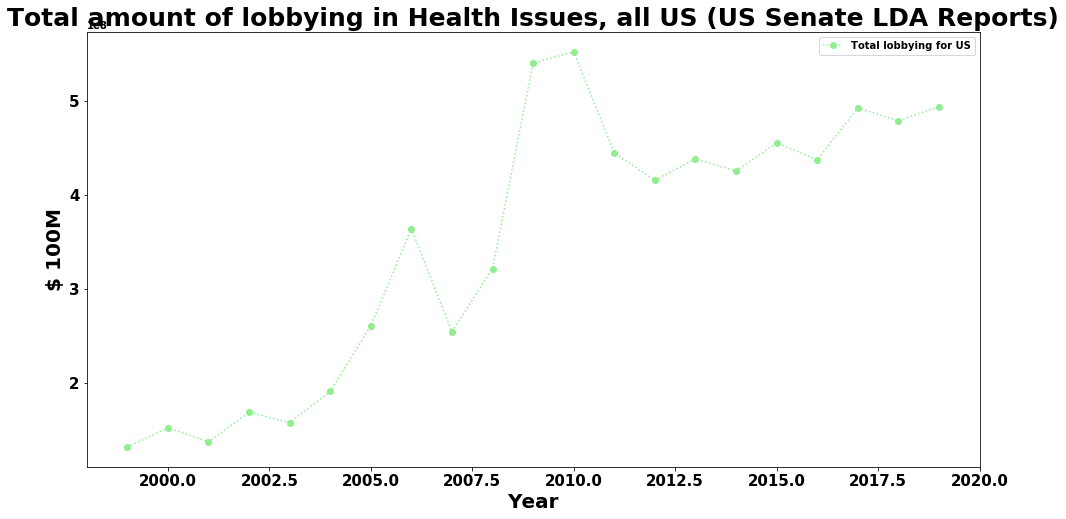

In [168]:
plt.figure(figsize=(16,8))
plt.title(f'Total amount of lobbying in Health Issues, all US (US Senate LDA Reports)', fontsize=25)
 
plt.plot(my_years2, data2.total_amount,
             color = 'lightgreen',
             linestyle = 'dotted',
             marker = 'o',
             label = f'Total lobbying for US')
                                
plt.xlabel('Year',fontsize=20)
plt.ylabel('$ 100M',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='best');

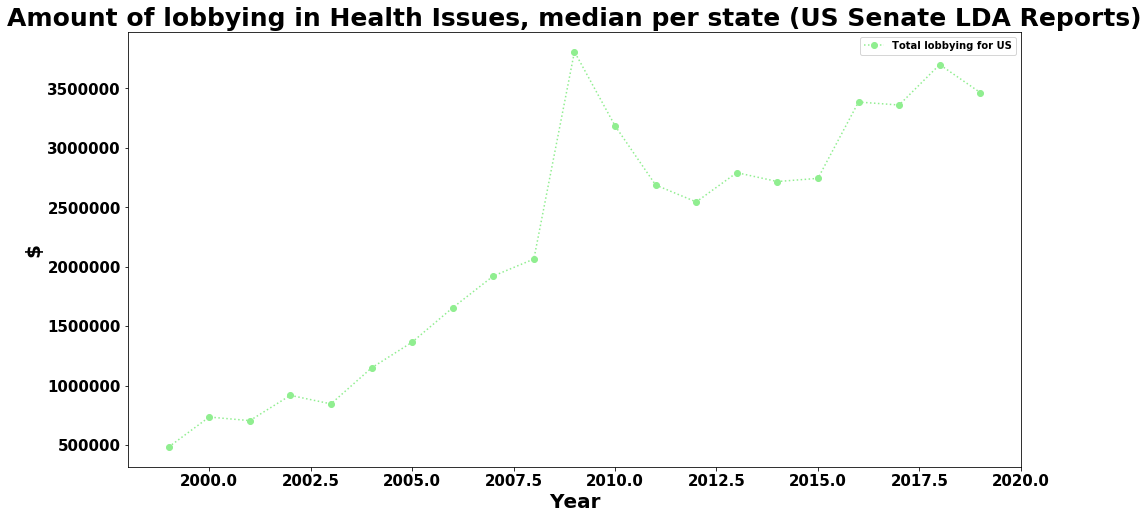

In [164]:
plt.figure(figsize=(16,8))
plt.title(f'Amount of lobbying in Health Issues, median per state (US Senate LDA Reports)', fontsize=25)
 
plt.plot(my_years2, data2.med_amount,
             color = 'lightgreen',
             linestyle = 'dotted',
             marker = 'o',
             label = f'Median per state')
                                
plt.xlabel('Year',fontsize=20)
plt.ylabel('$',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='best');

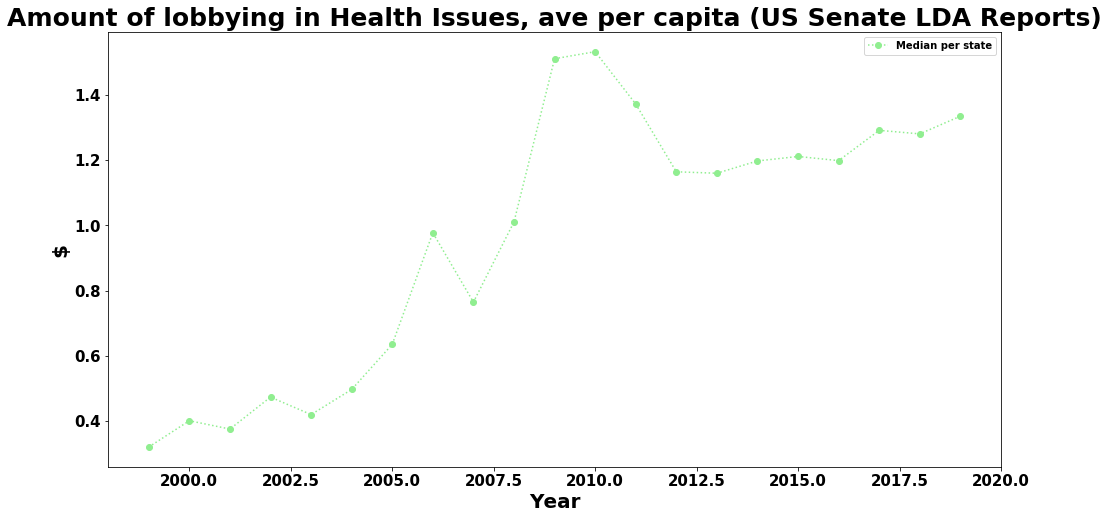

In [167]:
plt.figure(figsize=(16,8))
plt.title(f'Amount of lobbying in Health Issues, ave per capita (US Senate LDA Reports)', fontsize=25)
 
plt.plot(my_years2, data2.ave_per_cap,
             color = 'lightgreen',
             linestyle = 'dotted',
             marker = 'o',
             label = f'Median per state')
                                
plt.xlabel('Year',fontsize=20)
plt.ylabel('$',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='best');

In [169]:
def my_statelobby1(state_choice5,state_choice6):
    plt.figure(figsize=(16,8))
    plt.title(f'Comparing healthcare lobbying for {state_choice5} and {state_choice6} (US Senate)', fontsize=25)
 
    plt.plot(my_years2, data2[f'{state_choice5}amount'],
             color = 'lightgreen',
             linestyle = 'dotted',
             marker = 'o',
             label = f'{state_choice5} total lobbying')

    plt.plot(my_years2, data2[f'{state_choice6}amount'],
             color = 'orange',
             linestyle = 'dotted',
             marker = 'o',
             label = f'{state_choice6} total lobbying')
                                          
    plt.xlabel('Year',fontsize=20)
    plt.ylabel('Paid to lobbyists ($10M)',fontsize=20)
    #lt.ylim(6000, 18000)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.legend(loc='best');
    
state_select5 = widget.Select(
    options=my_states,
    value='AL',
    #rows=10,
    description='State1:',
    disabled=False
    )
    
state_select6 = widget.Select(
    options=my_states,
    value='CT',
    #rows=10,
    description='State2:',
    disabled=False
    )    

widget.interact(my_statelobby1, state_choice5=state_select5, state_choice6= state_select6)   

interactive(children=(Select(description='State1:', index=1, options=('AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT'…

<function __main__.my_statelobby1(state_choice5, state_choice6)>

In [53]:
def my_statelobby2(state_choice7,state_choice8):
    plt.figure(figsize=(16,8))
    plt.title(f'Comparing healthcare lobbying per capita for {state_choice7} and {state_choice8} (US Senate)', fontsize=25)
 
    plt.plot(s[state_choice7]['year'], s[state_choice7][f'{state_choice7}per_cap'],
             color = 'lightgreen',
             linestyle = 'dotted',
             marker = 'o',
             label = f'{state_choice7} total lobbying')

    plt.plot(s[state_choice8]['year'], s[state_choice8][f'{state_choice8}per_cap'],
             color = 'orange',
             linestyle = 'dotted',
             marker = 'o',
             label = f'{state_choice8} total lobbying')
                                          
    plt.xlabel('Year',fontsize=20)
    plt.ylabel('Paid to lobbyists ($ percapita)',fontsize=20)
    #lt.ylim(6000, 18000)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.legend(loc='best');
    
state_select7 = widget.Select(
    options=my_states,
    value='AL',
    #rows=10,
    description='State1:',
    disabled=False
    )
    
state_select8 = widget.Select(
    options=my_states,
    value='CT',
    #rows=10,
    description='State2:',
    disabled=False
    )    

widget.interact(my_statelobby2, state_choice7=state_select7, state_choice8= state_select8)   

interactive(children=(Select(description='State1:', index=1, options=('AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT'…

<function __main__.my_statelobby2(state_choice7, state_choice8)>